In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import copy
import random
import math

In [2]:
LEARNING_RATE = 0.01
NUM_CLIENTS = 4
LOCAL_ROUNDS = [5,10,25]
SAMPLING_FRACTIONS = [0.2, 0.5, 0.9]
TOTAL_TRAINING_ROUNDS = 50
BATCH_SIZE = 128
LOCAL_ROUNDS_FOR_SAMPLING = 5
GLOBAL_ROUNDS_FOR_SAMPLING = 10
MOMENTUM = 0.9
SEED_NUM = 47

In [3]:
def state_dict_to_vector(sd):
  """Flatten state_dict tensors to one long vector (CPU) for norm computations."""
  vecs = []
  for k, v in sd.items():
    vecs.append(v.detach().cpu().view(-1))
  if len(vecs) == 0:
    return torch.tensor([0.0])
  return torch.cat(vecs)

def fedavg(global_model, train_loaders, device, local_rounds):
  criterion = nn.CrossEntropyLoss()
  num_clients = len(train_loaders)
  total_data = sum(len(loader.dataset) for loader in train_loaders)

  # To store each client's updated model parameters
  global_model.to(device)
  global_params = [torch.zeros_like(param) for param in global_model.parameters()]

  # Keep global state before updates (for drift)
  global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
  global_vec = state_dict_to_vector(global_state)

  accum_params = {k: torch.zeros_like(v.data, device='cpu') for k, v in global_model.state_dict().items()}
  per_client_drifts = []

  # --- Each client trains locally ---
  for loader in train_loaders:
    local_model = copy.deepcopy(global_model).to(device)
    optimizer = optim.SGD(local_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    local_model.train()
    for _ in range(local_rounds):
      for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = local_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # compute drift: ||theta_i - theta_g||_2 (flattened)
    local_state = local_model.state_dict()
    local_vec = state_dict_to_vector(local_state)
    drift_norm = torch.norm(local_vec - global_vec, p=2).item()
    per_client_drifts.append(drift_norm)

    # Aggregate model weights (not grads)
    Ni = len(loader.dataset)
    with torch.no_grad():
      for i, param in enumerate(local_model.parameters()):
        global_params[i] += (param.data * Ni / total_data)

  # --- Server averages model weights ---
  with torch.no_grad():
    for global_param, new_param in zip(global_model.parameters(), global_params):
      global_param.data = new_param.clone()

  avg_drift = float(np.mean(per_client_drifts))
  return avg_drift

def fedavg_selective_sampling(global_model, train_loaders, device, sample_fraction=1.0):
  criterion = nn.CrossEntropyLoss()
  num_clients = len(train_loaders)


  n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
  selected_indices = sorted(random.sample(range(num_clients), n_clients))
  selected_loaders = [train_loaders[i] for i in selected_indices]
  # To store each client's updated model parameters
  global_model.to(device)
  global_params = [torch.zeros_like(param) for param in global_model.parameters()]

  participating_client_ids = []
  participating_data = sum(len(loader.dataset) for loader in selected_loaders)
  print(f"Number of Clients = {len(selected_indices)}")
  # Keep global state before updates (for drift)
  global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
  global_vec = state_dict_to_vector(global_state)

  accum_params = {k: torch.zeros_like(v.data, device='cpu') for k, v in global_model.state_dict().items()}
  per_client_drifts = []

  # --- Each client trains locally ---
  for client_idx, loader in zip(selected_indices, selected_loaders):
    participating_client_ids.append(client_idx)
    local_model = copy.deepcopy(global_model).to(device)
    optimizer = optim.SGD(local_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    local_model.train()
    for _ in range(LOCAL_ROUNDS_FOR_SAMPLING):
      for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = local_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # compute drift: ||theta_i - theta_g||_2 (flattened)
    local_state = local_model.state_dict()
    local_vec = state_dict_to_vector(local_state)
    drift_norm = torch.norm(local_vec - global_vec, p=2).item()
    per_client_drifts.append(drift_norm)

    # Aggregate model weights (not grads)
    Ni = len(loader.dataset)
    with torch.no_grad():
      for i, param in enumerate(local_model.parameters()):
        global_params[i] += (param.data * Ni / participating_data)

  # --- Server averages model weights ---
  with torch.no_grad():
    for global_param, new_param in zip(global_model.parameters(), global_params):
      global_param.data = new_param.clone()

  avg_drift = float(np.mean(per_client_drifts))

  return avg_drift

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [5]:
def get_data_loaders(num_clients=NUM_CLIENTS, batch_size=BATCH_SIZE):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])

  train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # Random IID split among clients
  data_per_client = len(train_dataset) // num_clients
  lengths = [data_per_client] * num_clients
  subsets = random_split(train_dataset, lengths)

  train_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subsets]
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loaders, test_loader

def evaluate(model, test_loader, device):
  model.eval()
  correct, total, test_loss = 0, 0, 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return test_loss / total, 100 * correct / total

In [11]:
train_loaders, test_loader = get_data_loaders(num_clients=4, batch_size=64)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# FedAvg on Different Number of Local Rounds

In [ ]:
test_accuracies = []
test_losses = []
avg_drifts = []

initialisation_model = SimpleCNN()
initialisation_model.to(device)

for local in LOCAL_ROUNDS:
  print(f"K = {local}")
  global_model = copy.deepcopy(initialisation_model)
  global_rounds = TOTAL_TRAINING_ROUNDS//local
  drifts = []
  for round in range(global_rounds):
    avg_drift = fedavg(global_model, train_loaders, device, local)
    drifts.append(avg_drift)
    fed_loss, fed_acc = evaluate(global_model, test_loader, device)
    print(f"Round {round+1:02d}:")
    print(f"  FedSGD → Test Loss: {fed_loss:.4f}, Test Acc: {fed_acc:.2f}%, Average Client Drift: {avg_drift}")

  avg_drifts.append(drifts)
  test_accuracies.append(fed_acc)
  test_losses.append(fed_loss)
  torch.save(global_model.state_dict(), f"global_model_{local}.pth")

K = 5
Round 01:
  FedSGD → Test Loss: 1.1061, Test Acc: 60.54%, Average Client Drift: 7.377638339996338
Round 02:
  FedSGD → Test Loss: 0.8520, Test Acc: 70.84%, Average Client Drift: 7.999613523483276
Round 03:
  FedSGD → Test Loss: 0.8648, Test Acc: 74.43%, Average Client Drift: 8.406489849090576
Round 04:
  FedSGD → Test Loss: 1.0135, Test Acc: 75.38%, Average Client Drift: 7.653890490531921
Round 05:
  FedSGD → Test Loss: 1.1214, Test Acc: 76.72%, Average Client Drift: 6.864962935447693
Round 06:
  FedSGD → Test Loss: 1.1641, Test Acc: 77.21%, Average Client Drift: 6.5379780530929565
Round 07:
  FedSGD → Test Loss: 1.2068, Test Acc: 77.10%, Average Client Drift: 6.172948598861694
Round 08:
  FedSGD → Test Loss: 1.2239, Test Acc: 77.40%, Average Client Drift: 6.127666473388672
Round 09:
  FedSGD → Test Loss: 1.2473, Test Acc: 77.19%, Average Client Drift: 5.795156359672546
Round 10:
  FedSGD → Test Loss: 1.2700, Test Acc: 77.17%, Average Client Drift: 5.341204524040222
K = 10
Round 

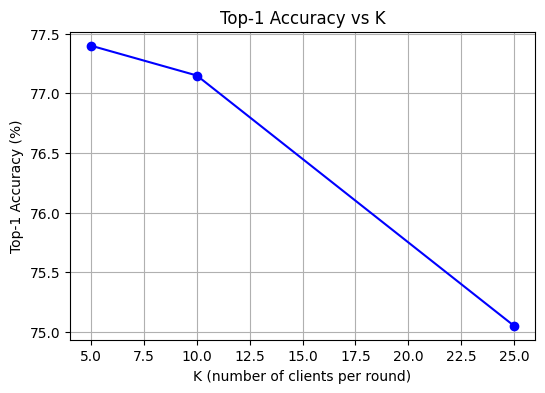

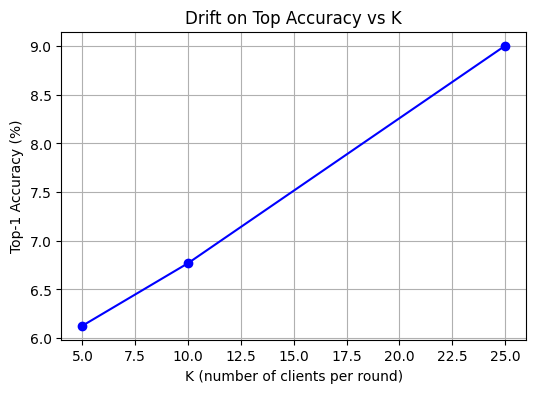

In [21]:
import matplotlib.pyplot as plt

# Values
K_values = [5, 10, 25]
top1_acc = [77.40, 77.15, 75.05]
driftattopacc = [6.127666473388672, 6.770500659942627, 9.004425287246704]

# Plot
plt.figure(figsize=(6,4))
# plt.subplot(1,2,1)
plt.plot(K_values, top1_acc, marker='o', linestyle='-', color='b')
plt.title("Top-1 Accuracy vs K")
plt.xlabel("K (number of clients per round)")
plt.ylabel("Top-1 Accuracy (%)")
plt.grid(True)
plt.show()
plt.figure(figsize=(6,4))
# plt.subplot(1,2,2)
plt.plot(K_values, driftattopacc, marker='o', linestyle='-', color='b')
plt.title("Drift on Top Accuracy vs K")
plt.xlabel("K (number of clients per round)")
plt.ylabel("Top-1 Accuracy (%)")
plt.grid(True)
plt.show()


# Selective Sampling

In [7]:
sampling_accuracies = []
sampling_losses = []
sampling_drifts = []

initialisation_model = SimpleCNN()
# initialisation_model.load_state_dict(torch.load("init_model.pth"))

for sample in SAMPLING_FRACTIONS:
  print(f"f = {sample}")
  global_model = copy.deepcopy(initialisation_model)
  drifts = []
  for round in range(GLOBAL_ROUNDS_FOR_SAMPLING):
    avg_drift = fedavg_selective_sampling(global_model, train_loaders, device, sample_fraction=sample)
    drifts.append(avg_drift)
    fed_loss, fed_acc = evaluate(global_model, test_loader, device)
    print(f"Round {round+1:02d}:")
    print(f"  FedSGD → Test Loss: {fed_loss:.4f}, Test Acc: {fed_acc:.2f}%, Average Client Drift: {avg_drift}")

  sampling_drifts.append(drifts)
  sampling_accuracies.append(fed_acc)
  sampling_losses.append(fed_loss)
  torch.save(global_model.state_dict(), f"global_model_sample_{sample}.pth")

f = 0.2
Number of Clients = 1
Round 01:
  FedSGD → Test Loss: 1.1907, Test Acc: 57.17%, Average Client Drift: 7.39000940322876
Number of Clients = 1
Round 02:
  FedSGD → Test Loss: 1.0184, Test Acc: 66.01%, Average Client Drift: 8.203893661499023
Number of Clients = 1
Round 03:
  FedSGD → Test Loss: 1.4561, Test Acc: 66.78%, Average Client Drift: 7.44795036315918
Number of Clients = 1
Round 04:
  FedSGD → Test Loss: 1.9399, Test Acc: 68.06%, Average Client Drift: 4.320314407348633
Number of Clients = 1
Round 05:
  FedSGD → Test Loss: 1.2212, Test Acc: 69.75%, Average Client Drift: 9.657421112060547
Number of Clients = 1
Round 06:
  FedSGD → Test Loss: 1.6451, Test Acc: 71.86%, Average Client Drift: 1.95548415184021
Number of Clients = 1
Round 07:
  FedSGD → Test Loss: 2.1936, Test Acc: 69.24%, Average Client Drift: 6.907839775085449
Number of Clients = 1
Round 08:
  FedSGD → Test Loss: 1.6172, Test Acc: 72.43%, Average Client Drift: 5.277276039123535
Number of Clients = 1
Round 09:
  F

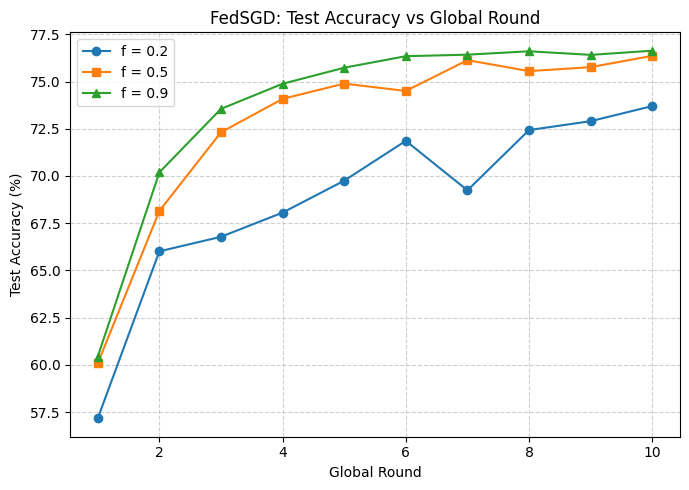

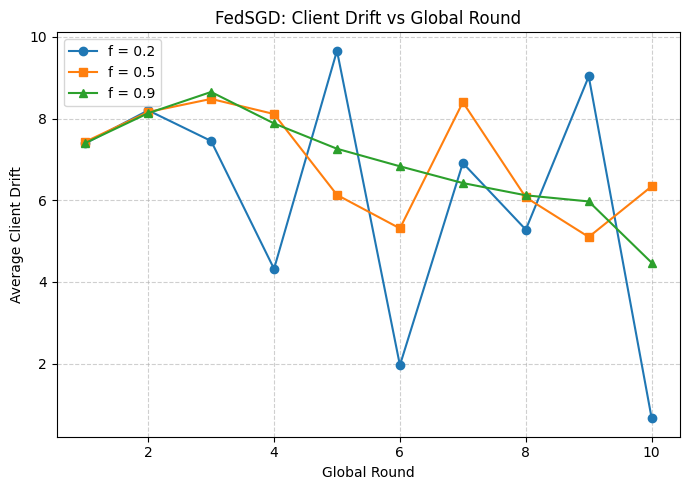

In [8]:
import matplotlib.pyplot as plt

# === Data ===
rounds = list(range(1, 11))

# f = 0.2
acc_02 = [57.17, 66.01, 66.78, 68.06, 69.75, 71.86, 69.24, 72.43, 72.90, 73.70]
drift_02 = [7.39, 8.20, 7.45, 4.32, 9.66, 1.96, 6.91, 5.28, 9.03, 0.66]

# f = 0.5
acc_05 = [60.08, 68.15, 72.31, 74.08, 74.89, 74.50, 76.13, 75.55, 75.76, 76.36]
drift_05 = [7.43, 8.16, 8.48, 8.11, 6.13, 5.31, 8.40, 6.07, 5.10, 6.34]

# f = 0.9
acc_09 = [60.44, 70.19, 73.55, 74.88, 75.73, 76.34, 76.42, 76.60, 76.41, 76.63]
drift_09 = [7.40, 8.13, 8.65, 7.88, 7.26, 6.83, 6.42, 6.12, 5.97, 4.47]

# === Plot 1: Test Accuracy ===
plt.figure(figsize=(7, 5))
plt.plot(rounds, acc_02, marker='o', label='f = 0.2')
plt.plot(rounds, acc_05, marker='s', label='f = 0.5')
plt.plot(rounds, acc_09, marker='^', label='f = 0.9')
plt.xlabel('Global Round')
plt.ylabel('Test Accuracy (%)')
plt.title('FedSGD: Test Accuracy vs Global Round')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Plot 2: Average Client Drift ===
plt.figure(figsize=(7, 5))
plt.plot(rounds, drift_02, marker='o', label='f = 0.2')
plt.plot(rounds, drift_05, marker='s', label='f = 0.5')
plt.plot(rounds, drift_09, marker='^', label='f = 0.9')
plt.xlabel('Global Round')
plt.ylabel('Average Client Drift')
plt.title('FedSGD: Client Drift vs Global Round')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torch

def plot_class_distributions(train_loaders, num_classes=10):
    class_dists = []

    # compute class percentage for each client
    for loader in train_loaders:
        if hasattr(loader.dataset, 'targets'):
            labels = loader.dataset.targets
        elif hasattr(loader.dataset, 'labels'):
            labels = loader.dataset.labels
        else:
            labels = []
            for _, y in loader:
                labels.extend(y.tolist())
            labels = torch.tensor(labels)

        counts = Counter(labels.tolist())
        total = sum(counts.values())
        percents = [counts.get(c, 0) / total * 100 for c in range(num_classes)]
        class_dists.append(percents)

    # plot
    class_labels = np.arange(num_classes)
    width = 0.8 / len(train_loaders)  # to fit all clients side-by-side

    plt.figure(figsize=(10, 6))
    for i, dist in enumerate(class_dists):
        plt.bar(class_labels + i * width, dist, width=width, label=f'Client {i+1}', alpha=0.8)

    plt.xticks(class_labels + width*(len(train_loaders)/2 - 0.5), [str(i) for i in range(num_classes)])
    plt.xlabel("Class Label")
    plt.ylabel("Percentage (%)")
    plt.title("Class Distribution per Client")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# plot_class_distributions(train_loaders, num_classes=10)

# Data Heterogeneity

In [7]:
ALPHA_DIR = [0.05, 1, 100]
NUM_CLIENTS = 5
LOCAL_ROUNDS = 10
GLOBAL_ROUNDS = 10
LEARNING_RATE = 0.01

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [8]:
!pip install fedlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fedlab: filename=fedlab-1.3.0-py3-none-any.whl size=96033 sha256=c1bbc35efe992bba71c30e183b3345eebe5a3d96f126383afc11d18f33cdc4d7
  Stored in directory: /root/.cache/pip/wheels/6a/19/2d/cc722e9b1756a1d5d204b769e3bc052bf91ecb3f0f3ad4ba23
Successfully built fedlab


In [9]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner


heter_loaders = {}

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

for a in ALPHA_DIR:
  hetero_dir_part = CIFAR10Partitioner(train_dataset.targets,
                                      NUM_CLIENTS,
                                      balance=None,
                                      partition="dirichlet",
                                      dir_alpha=a,
                                      seed=SEED_NUM)

  client_loaders = [
    DataLoader(Subset(train_dataset, hetero_dir_part.client_dict[i]), batch_size=BATCH_SIZE, shuffle=True)
    for i in range(NUM_CLIENTS)
  ]
  heter_loaders[a] = client_loaders

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


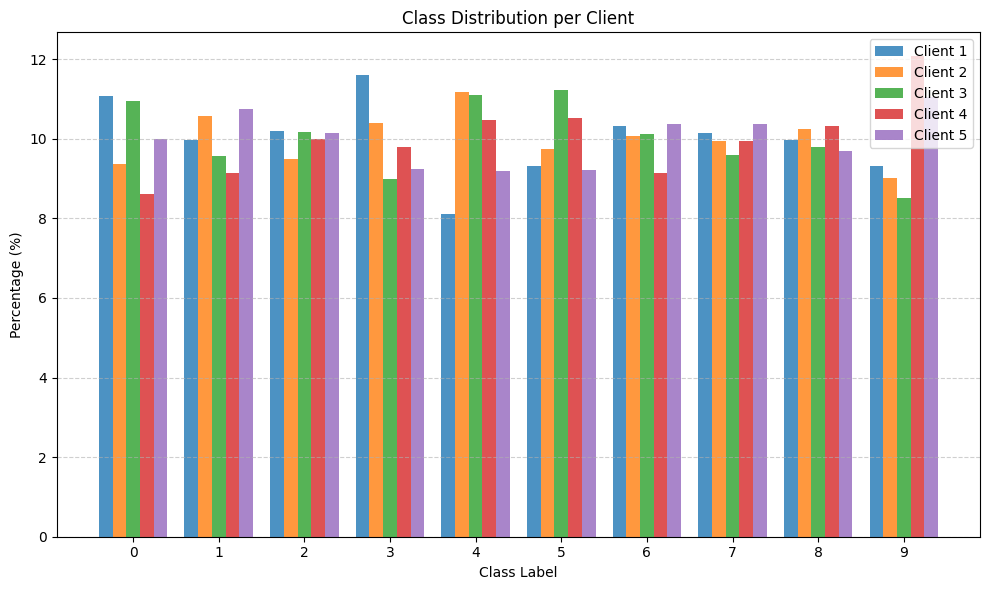

In [12]:
plot_class_distributions(heter_loaders[100], num_classes=10)

In [12]:
alpha_accuracies = []
alpha_losses = []
alpha_drifts = []

initialisation_model = SimpleCNN()
# initialisation_model.load_state_dict(torch.load("init_model.pth"))
print(f"---- Global Comunication rounds = {GLOBAL_ROUNDS}, Local Communication Rounds = {LOCAL_ROUNDS} ----")
for alpha, train_loaders in heter_loaders.items():
  print(f"a = {alpha}")
  global_model = copy.deepcopy(initialisation_model)
  drifts = []
  for round in range(GLOBAL_ROUNDS):
    avg_drift = fedavg(global_model, train_loaders, device, local_rounds=LOCAL_ROUNDS)
    drifts.append(avg_drift)
    fed_loss, fed_acc = evaluate(global_model, test_loader, device)
    print(f"Round {round+1:02d}:")
    print(f"  FedSGD → Test Loss: {fed_loss:.4f}, Test Acc: {fed_acc:.2f}%, Average Client Drift: {avg_drift}")

  alpha_drifts.append(drifts)
  alpha_accuracies.append(fed_acc)
  alpha_losses.append(fed_loss)
  torch.save(global_model.state_dict(), f"global_model_alpha_{alpha}.pth")

---- Global Comunication rounds = 10, Local Communication Rounds = 10 ----
a = 0.05
Round 01:
  FedSGD → Test Loss: 2.1633, Test Acc: 16.08%, Average Client Drift: 4.6131720542907715
Round 02:
  FedSGD → Test Loss: 1.6917, Test Acc: 39.19%, Average Client Drift: 4.637261629104614
Round 03:
  FedSGD → Test Loss: 1.3539, Test Acc: 51.60%, Average Client Drift: 4.58040189743042
Round 04:
  FedSGD → Test Loss: 1.2818, Test Acc: 55.93%, Average Client Drift: 4.084705209732055
Round 05:
  FedSGD → Test Loss: 1.4971, Test Acc: 54.86%, Average Client Drift: 3.3286710739135743
Round 06:
  FedSGD → Test Loss: 2.1803, Test Acc: 46.47%, Average Client Drift: 3.0411677837371824
Round 07:
  FedSGD → Test Loss: 3.0373, Test Acc: 39.45%, Average Client Drift: 2.824733352661133
Round 08:
  FedSGD → Test Loss: 2.0201, Test Acc: 40.85%, Average Client Drift: 3.625509834289551
Round 09:
  FedSGD → Test Loss: 1.5449, Test Acc: 55.90%, Average Client Drift: 2.495021843910217
Round 10:
  FedSGD → Test Loss: 

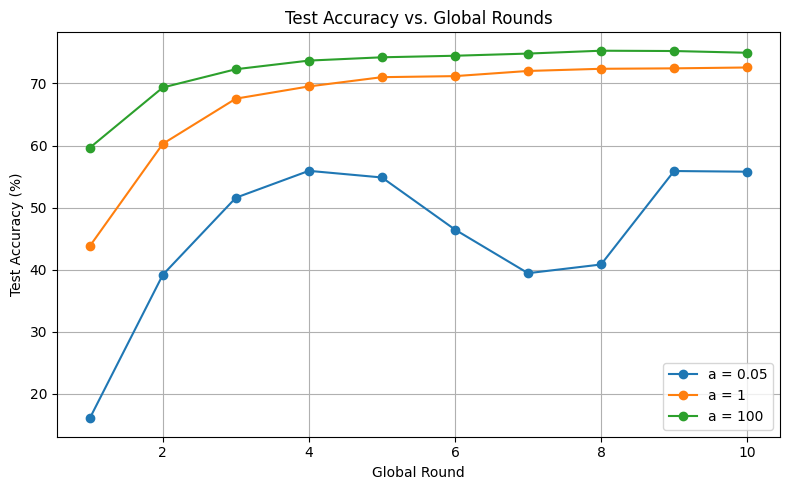

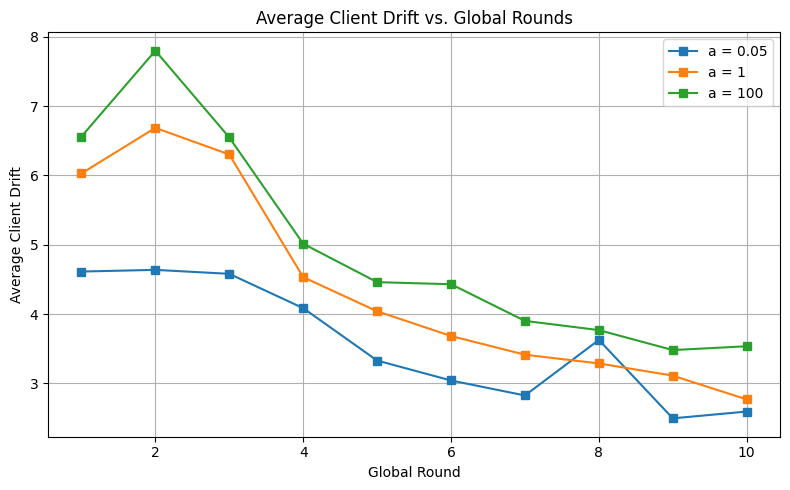

In [13]:
import matplotlib.pyplot as plt

rounds = list(range(1, 11))

# Accuracy (%)
acc_a005 = [16.08, 39.19, 51.60, 55.93, 54.86, 46.47, 39.45, 40.85, 55.90, 55.79]
acc_a1 =    [43.80, 60.28, 67.55, 69.52, 71.01, 71.18, 72.01, 72.36, 72.43, 72.57]
acc_a100 =  [59.64, 69.35, 72.29, 73.68, 74.21, 74.46, 74.81, 75.27, 75.22, 74.94]

# Client Drift
drift_a005 = [4.613, 4.637, 4.580, 4.085, 3.329, 3.041, 2.825, 3.626, 2.495, 2.593]
drift_a1 =   [6.028, 6.686, 6.302, 4.532, 4.040, 3.683, 3.413, 3.287, 3.111, 2.768]
drift_a100 = [6.560, 7.799, 6.548, 5.014, 4.460, 4.430, 3.901, 3.768, 3.480, 3.535]

# --- Plot 1: Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(rounds, acc_a005, marker='o', label='a = 0.05')
plt.plot(rounds, acc_a1, marker='o', label='a = 1')
plt.plot(rounds, acc_a100, marker='o', label='a = 100')
plt.title('Test Accuracy vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Client Drift ---
plt.figure(figsize=(8,5))
plt.plot(rounds, drift_a005, marker='s', label='a = 0.05')
plt.plot(rounds, drift_a1, marker='s', label='a = 1')
plt.plot(rounds, drift_a100, marker='s', label='a = 100')
plt.title('Average Client Drift vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Average Client Drift')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
